# Importing Libraries for Preprocessing the Data:

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing:

The code below performs textual data preprocessing on training and testing datasets loaded from Google Drive. Initial data loading using Pandas is followed by the definition of two functions, isNaN and text_processing. Text processing involves sequential steps: removal of digits, non-ASCII characters, conversion to lowercase, elimination of hyperlinks, punctuation, and stop words. This is fllowed by tokenization,and lemmatization to ensure that similar meaning words are considered as the same instance. Any comment that would be too aggressively processed such that it has no tokens left is replaced by 'empty'. The preprocessed data is then saved as CSV files on Google Drive for ease of use. This holistic approach ensures a standardized and cleaned text dataset,allowing for use for the multiple models to come in the following notebooks.

In [ ]:
data_train=pd.read_csv('/content/drive/MyDrive/train.csv')
data_test=pd.read_csv('/content/drive/MyDrive/test.csv')
process_test=pd.read_csv('/content/drive/MyDrive/processed_test.csv') # obtained after preprocessing / skip preprocessing block
process_train=pd.read_csv('/content/drive/MyDrive/processed_train.csv') # obtained after preprocessing / skip preprocessing block

In [ ]:
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
process_train=data_train.copy(deep=True)
process_test=data_test.copy(deep=True)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def isNaN(string):
    return string != string

def text_processing(text):
  text = re.sub(r'[0-9]+',' ', text) #remove all digits
  text=re.sub(r'[^\x00-\x7f]',' ',text) #removes non ascii
  text=text.lower() #lower case
  text= re.sub('http[s]?://\S+', ' ', text) #remove links
  text = re.sub(r'[^\w\s]+',' ',text) #remove punctuations and special characters
  tokens=word_tokenize(text) #tokenizer
  tokens=[word for word in tokens if word not in stop_words] #remove stop words
  tokens=[word for word in tokens if word.isalnum()]#second pass for punctuation and special characters removal
  tokens=[lemmatizer.lemmatize(word) for word in tokens] #lemmatization of word tokens
  text=' '.join(tokens)
  if isNaN(text) or text=='':
    return 'empty'
  return text

process_train['comment_text']=process_train['comment_text'].apply(text_processing)
process_test['comment_text']=process_test['comment_text'].apply(text_processing)
process_train.to_csv('/content/drive/MyDrive/processed_train.csv')
process_test.to_csv('/content/drive/MyDrive/processed_test.csv')

Check the data preprocessing by printing a few examples

In [ ]:
data_train[data_train['toxic']==1][['comment_text','toxic','severe_toxic','obscene','threat','insult','identity_hate']].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [ ]:
process_train[process_train['toxic']==1][['comment_text','toxic','severe_toxic','obscene','threat','insult','identity_hate']].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,cocksucker piss around work,1,1,1,0,1,0
12,hey talk exclusive group wp taliban good destr...,1,0,0,0,0,0
16,bye look come think comming back tosser,1,0,0,0,0,0
42,gay antisemmitian archangel white tiger meow g...,1,0,1,0,1,1
43,fuck filthy mother as dry,1,0,1,0,1,0


In [ ]:
data_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
process_test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information updated correct f...
4,00017695ad8997eb,anonymously edit article


# Visulaizing the Training Dataset

> This section checks for data imbalances by visualizing the proportion of each of the multiple labels in the complete dataset.




<Axes: title={'center': 'Toxic Ratios'}, ylabel='Frequency'>

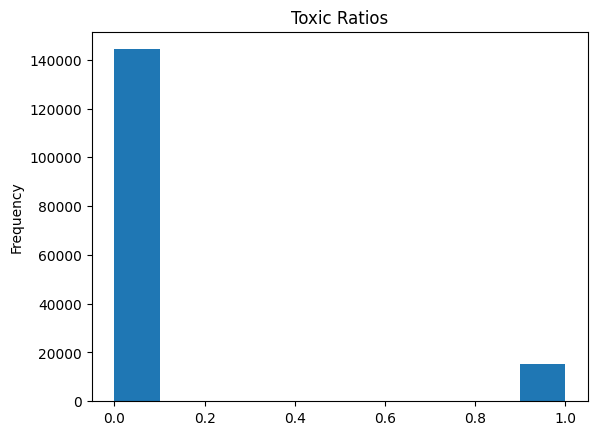

In [ ]:
ratios=process_train.drop(columns=['comment_text'])
ratios['toxic'].plot(kind='hist',title='Toxic Ratios')

In [ ]:
print('Total Samples:',ratios['toxic'].shape[0])
print("Toxic:", ratios['toxic'].sum())
print("Non Toxic:",(ratios['toxic']==0).sum())
print("Percentage(Toxic):", "%.3f" % (100*(ratios['toxic'].sum())/(ratios['toxic'].shape[0])),'%')

Total Samples: 159571
Toxic: 15294
Non Toxic: 144277
Percentage(Toxic): 9.584 %


Clearly, there is a great data imbalance with toxic data samples constituting around 10% of the non-toxic ones. We will undersample the non-toxic data to create relatively balanced datasets (from 10:1 imbalance to 60:40 e.g.), Then we will compare the performances with both balanced and unbalanced datasets. Before that, let's investigate further data imbalances within the toxic samples.

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


<Axes: title={'center': 'Toxic Samples Breakdown'}>

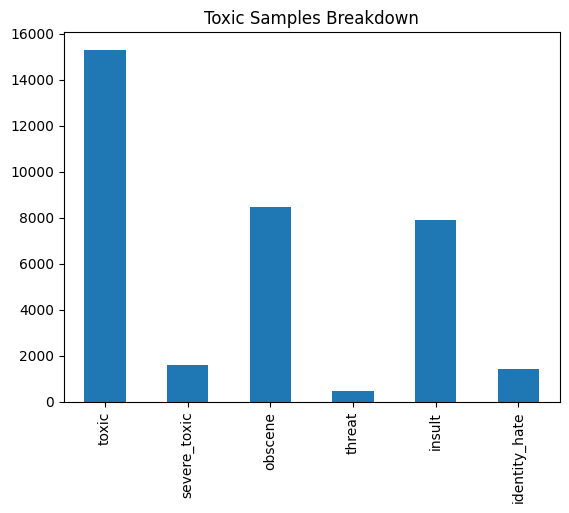

In [ ]:
sums=ratios[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum()
print(sums)
sums.plot(kind='bar',title='Toxic Samples Breakdown')

Since the five sub categories are closely related to the toxic class (i.e. they are mostly '1' if toxic is '1') for each of these sub categories, the training dataset will mostly include samples which are labelled as toxic.  Since 'severe_toxic', 'threat' and 'identity_hate' categories constitute a very small proportion of the training dataset, we will have to undersample the data set for these categories as well, much like the toxic data set to allow for data balancing. Regardless of the balancing techniques, the F1-score and AUC-ROC will be the primary metrics for testing the model rather than accuracy. The raw imbalanced datasets will also be used in training for this model to test the balance between importance of balanced datasets and larger training data.

# Creating Balanced Datasets:

This section balances the distribution of different toxic comment categories within the training dataset by oversampling the minority class. We create balanced subsets for each toxicity category, including 'toxic,' 'severe_toxic,' 'obscene,' 'threat,' 'insult,' and 'identity_hate.' For each category, the script concatenates the instances labeled as 1 (indicating the presence of toxicity) with a randomly sampled subset of instances labeled as 0 (indicating non-toxic) to achieve a balanced representation. The size of the non-toxic subset is twice the count of toxic instances for each category. The resulting balanced subsets are then shuffled using the 'sample' function with 'frac=1' to randomize the order of instances. Finally, each balanced subset is further reduced to include only the 'comment_text' and corresponding toxicity label columns. TThis creates 6 balanced subsets for each of the six classes ensuring  balanced representations for training our classifiers.

In [ ]:
balanced_toxic=pd.concat([process_train[process_train['toxic']==1],process_train[process_train['toxic']==0].sample(frac=1).iloc[:int(2*sums['toxic'])]],ignore_index=True).sample(frac=1)
balanced_severe_toxic=pd.concat([process_train[process_train['severe_toxic']==1],process_train[process_train['severe_toxic']==0].sample(frac=1).iloc[:int(2*sums['severe_toxic'])]],ignore_index=True).sample(frac=1)
balanced_obscene=pd.concat([process_train[process_train['obscene']==1],process_train[process_train['obscene']==0].sample(frac=1).iloc[:int(2*sums['obscene'])]],ignore_index=True).sample(frac=1)
balanced_threat=pd.concat([process_train[process_train['threat']==1],process_train[process_train['threat']==0].sample(frac=1).iloc[:int(2*sums['threat'])]],ignore_index=True).sample(frac=1)
balanced_insult=pd.concat([process_train[process_train['insult']==1],process_train[process_train['insult']==0].sample(frac=1).iloc[:int(2*sums['insult'])]],ignore_index=True).sample(frac=1)
balanced_identity_hate=pd.concat([process_train[process_train['identity_hate']==1],process_train[process_train['identity_hate']==0].sample(frac=1).iloc[:int(2*sums['identity_hate'])]],ignore_index=True).sample(frac=1)

balanced_toxic=balanced_toxic[['comment_text','toxic']]
balanced_severe_toxic=balanced_severe_toxic[['comment_text','severe_toxic']]
balanced_obscene=balanced_obscene[['comment_text','obscene']]
balanced_threat=balanced_threat[['comment_text','threat']]
balanced_insult=balanced_insult[['comment_text','insult']]
balanced_identity_hate=balanced_identity_hate[['comment_text','identity_hate']]

In [ ]:
# Display the shape (number of rows and columns) of the balanced 'toxic' subset
print("Balanced 'Toxic' subset:", balanced_toxic.shape)

# Display the shape of the balanced 'insult' subset
print("Balanced 'Insult' subset:", balanced_insult.shape)

# Display the shape of the balanced 'obscene' subset
print("Balanced 'Obscene' subset:", balanced_obscene.shape)

# Display the shape of the balanced 'severe_toxic' subset
print("Balanced 'Severe Toxic' subset:", balanced_severe_toxic.shape)

# Display the shape of the balanced 'threat' subset
print("Balanced 'Threat' subset:", balanced_threat.shape)

# Display the shape of the balanced 'identity_hate' subset
print("Balanced 'Identity Hate' subset:", balanced_identity_hate.shape)


Balanced 'Toxic' subset: (45882, 2)
Balanced 'Insult' subset: (23631, 2)
Balanced 'Obscene' subset: (25347, 2)
Balanced 'Severe Toxic' subset: (4785, 2)
Balanced 'Threat' subset: (1434, 2)
Balanced 'Identity Hate' subset: (4215, 2)


# Importing Libraries for Naive Bayes Processing:

**Importing Libraries:**
We import essential libraries, including scikit-learn components such as TfidfVectorizer and various Naive Bayes classifiers (MultinomialNB, ComplementNB, BernoulliNB, and GaussianNB). Additional libraries for data manipulation, model evaluation, and visualization are also imported, such as pandas, matplotlib, seaborn, and sklearn's metrics modules.

**Building the Test Dataset:**
The test dataset in the 'test_labels.csv' file, contains labeled toxic comment data with their ids. However, the majority of these labels are '-1' which means they were not use for scoring and hence their actual labels cannot be known. These must be removed. We first combine the comment text from the preprocessed test set (process_test) with the corresponding toxic labels and then filter out instances labeled as -1. The resulting test set (test_set) is structured to include the comment text and the toxic labels, which are then split into the input features (X_test, comment text) and the target labels (Y_test, toxic categories).

**Vectorizing Text Data:**
The next steps involve vectorizing the comment text using different vectorizers like Count Vectors, Occurence Vectors (by setting CountVectorizer parameter binary= True), and TF-IDF Vectors, each of which are sparse representations which transform the raw text token by token into a numerical format suitable for machine learning. We have limited ourselves to 1-gram and not employed other n-grams. This was partially to not outrightly violate the "naive" assumption of Naive Bayes (i.e. the independence in distribution of independent features i.e. tokens).

**MultiOutputClassifier:**
To handle multiple toxic categories simultaneously, the MultiOutputClassifier is employed, allowing the Naive Bayes models to predict each category independently.

# **Motivating Naive Bayes**:
To ensure that Naive Bayes can and is rightfully popularly used for text classification tasks despite being a very simple probabilistic classifier we employ the most basic approach using Occurence Vectors and BernoulliNaiveBayes (i.e. each feature is either a 0 or 1 (unique token present or absent)).

**Training the Bernoulli Naive Bayes Model:**
The Bernoulli Naive Bayes model is selected for this classification task, suitable for binary data like the one-hot encoded vectors produced by the CountVectorizer. The model is instantiated, and the CountVectorizer is fitted on the training comment text from the processed training dataset (process_train). The training data is then transformed into a feature matrix (X_train).

**Model Prediction and Evaluation:**
The trained model is used to predict toxic labels for the test dataset (X_transform). Performance metrics, including F1 scores, accuracy, and the area under the ROC curve (AUC), are computed using scikit-learn's metrics functions. The results are then printed using the print_results function, providing a detailed breakdown of F1 scores for each toxic category, overall AUC, and accuracy.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
import seaborn as sns

In [ ]:
# build the test dataset
Y_test=pd.read_csv('/content/drive/MyDrive/test_labels.csv')
test_set=pd.concat([process_test['comment_text'],Y_test],axis=1)
test_set=test_set[test_set['toxic']!=-1]
Y_test=test_set[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].to_numpy()
X_test=test_set['comment_text']

In [ ]:
# Display the shape of the toxic labels in the test dataset
print("Shape of 'Toxic' test labels:", Y_test.shape)

# Display the shape of the comment text in the test dataset
print("Shape of 'Toxic' test features:", X_test.shape)  # Note: The strings have not been vectorized yet

Shape of 'Toxic' test labels: (63978, 6)
Shape of 'Toxic' test features: (63978,)


In [ ]:
def print_results(f1,AUC,accuracy):
  print("F1 Scores:")
  test_labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
  for i in range(len(f1)):
    print(test_labels[i],":","%.3f"% (f1[i]*100),"%")
  print("AUC:",":","%.3f"% (AUC*100),"%")
  print("Accuracy:",":","%.3f"% (accuracy*100),"%")

In [ ]:
model=BernoulliNB()
vec=CountVectorizer(binary=True)
vec.fit(process_train['comment_text'])
X_train=vec.transform(process_train['comment_text'])
Y_train=process_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_transform=vec.transform(X_test)
multi_model=MultiOutputClassifier(model)
multi_model.fit(X_train,Y_train)
predicted_labels=multi_model.predict(X_transform)
f1=f1_score(Y_test,predicted_labels,average=None)
accuracy=accuracy_score(Y_test,predicted_labels)
AUC=roc_auc_score(Y_test,predicted_labels)
print_results(f1,AUC,accuracy)

F1 Scores:
toxic : 59.551 %
severe_toxic : 0.436 %
obscene : 41.928 %
threat : 0.000 %
insult : 32.118 %
identity_hate : 0.734 %
AUC: : 59.756 %
Accuracy: : 85.290 %


**Discussion on Initial Results**

Even with poor F1-scores for certain classes, Naive Bayes is promising with a high accuracy (85.29%) without any tuning of hyperparameters, and is justifiably used in sentiment analysis. We will see soon that these poor F1-scores (for identity hate, threat, and sever_toxic) are due to imbalances in data (these categories being positive is very rare), rather than a limitation of Naive Bayes. We will however primarily employ other types of sparse vectorizers like TF-IDF and Count as those provide more information. The NB to be employed will have to be adjusted accordingly since our train features are not binary (they may be but not necessarily) any longer. Correspondingly, we use TF-IDF Vectors and Count Vectors.

# Explore Other Sparse Representations (TF-IDF and Count Vectors) and different Naive Bayes Architectures

We now delve deeper into the exploration of Naive Bayes models for predicting toxic comment categories, leveraging various vectorization techniques. The initial part is centered around Multinomial Naive Bayes, which utilizes the CountVectorizer and TF-IDF Vectorizer for text representation.The TfidfVectorizer computes the Term Frequency-Inverse Document Frequency (TF-IDF) values, offering a numerical representation that signifies the importance of words in the context of the entire dataset while the CountVectorizer computes the raw counts for each unique token. The CountVectorizer transforms text into numerical vectors by tallying word occurrences in each document. The training dataset undergoes vectorization, and the Multinomial Naive Bayes model is trained using the MultiOutputClassifier, enabling it to handle multiple output classes concurrently. The model is subsequently evaluated on the test dataset, and performance metrics such as F1 scores, accuracy, and the area under the ROC curve are computed and displayed using the print_results function.

**Multinomial and Complement Naive Bayes**

Multinomial Naive Bayes and Complement Naive Bayes are two variants of the Naive Bayes algorithm. While both are used for text classification tasks, they differ in their underlying assumptions and how they handle feature counts.

>Multinomial Naive Bayes:

Multinomial NB assumes that the features (word counts or term frequencies) follow a multinomial distribution and gives equal importance to each feature. It is well-suited for balanced textual datasets, so the inital expectation is that it will preform worse on the imbalanced datasets.

> Complement Naive Bayes:

Complement NB assumes that features are conditionally independent given the class.It is designed to address the issue of imbalanced class distribution in text classification by employing a complementary probability model that assigns more weight to features that are underrepresented in the training data.Hence it is particularly useful when dealing with imbalanced datasets, where certain classes have fewer instances than others.Thus, It can help address the problem of overfitting to the majority class. The initial hypothesis is that it will outperform Multinomial NB.

In the subsequent part, the script employs Complement Naive Bayes in conjunction with the the two vectorizors. Analogous to the Multinomial Naive Bayes section, the Complement Naive Bayes model is trained and evaluated on the test dataset, with performance metrics displayed using the print_results function.

These two sections contribute to a comparative analysis, illuminating how different Naive Bayes models, paired with unique text vectorization techniques, with different number of feature vectors (unique tokens) [as explored in the next section] perform in the specific task of identifying toxic comments. The evaluation results provide a nuanced understanding of the models' strengths and weaknesses, aiding in the selection of a suitable approach for an optimal Naive Bayes model.

In [ ]:
model=MultinomialNB()
vec=CountVectorizer()
vec.fit(process_train['comment_text'])
X_train=vec.transform(process_train['comment_text'])
Y_train=process_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_transform=vec.transform(X_test)
multi_model=MultiOutputClassifier(model)
multi_model.fit(X_train,Y_train)
predicted_labels=multi_model.predict(X_transform)
f1=f1_score(Y_test,predicted_labels,average=None)
accuracy=accuracy_score(Y_test,predicted_labels)
AUC=roc_auc_score(Y_test,predicted_labels)
print_results(f1,AUC,accuracy)

F1 Scores:
toxic : 61.917 %
severe_toxic : 25.893 %
obscene : 58.941 %
threat : 3.901 %
insult : 52.329 %
identity_hate : 23.439 %
AUC: : 71.617 %
Accuracy: : 87.349 %


In [ ]:
model=ComplementNB()
vec=TfidfVectorizer()
vec.fit(process_train['comment_text'])
X_train=vec.transform(process_train['comment_text'])
Y_train=process_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_transform=vec.transform(X_test)
multi_model=MultiOutputClassifier(model)
multi_model.fit(X_train,Y_train)
predicted_labels=multi_model.predict(X_transform)
f1=f1_score(Y_test,predicted_labels,average=None)
accuracy=accuracy_score(Y_test,predicted_labels)
AUC=roc_auc_score(Y_test,predicted_labels)
print_results(f1,AUC,accuracy)

F1 Scores:
toxic : 55.663 %
severe_toxic : 7.848 %
obscene : 49.161 %
threat : 1.121 %
insult : 42.137 %
identity_hate : 13.326 %
AUC: : 64.804 %
Accuracy: : 87.085 %


**Results:**
Both models exhibit moderate performance across toxic categories, with ‘toxic’ and ‘obscene’ scoring higher F1 scores, indicating effectiveness in identifying general toxicity. However, categories like severe toxicity, threats, insults, and identity hate score lower, suggesting challenges in distinguishing rarer forms of toxicity. The Multinomial model achieves an AUC of 71.617% and accuracy of 87.349%, slightly outperforming the Complement model with an AUC of 64.804% and accuracy of 87.085%. These results highlight the strengths and weaknesses of both models, aiding in the selection of an appropriate approach for future analyses and is quite contrary to our initial expectations. However, this is only one sample, and we could not select Multinomial NB over ComplementNB due to this especially when the Vectorizers used for both were different. We therefore turn to a more data-heavy approach for figuring out which vectorizer and Naive Bayes architecture is suitable for imbalanced data, while simultaneously figuring out the optimum number of feature vectors for each Vectorizers.

# Investigating the effect of different vectorizers and dimensionality of feature vectors on unbalanced data

This partciular section of the notebook explores the impact of varying the number of features (max_features) on the performance of Naive Bayes classifiers, specifically Complement Naive Bayes, and compares the results when using different vectorization techniques. The code defines a function, features_effects, that iterates over increasing numbers of features and records the resulting accuracies and F1 scores for both training and validation datasets. Two vectorization methods, CountVectorizer and TfidfVectorizer, are employed, and the Complement Naive Bayes and Multinomial Naive Bayes model serves as the classification algorithm.

The function is then called for both CountVectorizer and TfidfVectorizer with Complement Naive Bayes and Multinomial Naive Bayes models, generating lists of accuracies, F1 scores, and corresponding feature values. Subsequently, the script utilizes Matplotlib to create two plots for each vectorization method. The first plot illustrates how the accuracy changes with an increasing number of features, while the second plot displays the F1 scores for each toxic category over the same feature range. These visualizations provide insights into the optimal number of features that balance model complexity and performance for the given dataset.

In the specific examples provided, the plots show the effects of feature variation on the Complement Naive Bayes model using both CountVectorizer and TfidfVectorizer. The legend on each plot distinguishes accuracy from individual F1 scores for toxic comment categories.

In [ ]:
def features_effects(vectorizer,model):
  accuracies=[]
  f1_scores=[]
  max_features=[]
  for i in range (1,150):
    word=1000*i
    max_features.append(word)
    vec = vectorizer(max_features=word)
    vec.fit(process_train['comment_text']) # learn complete training vocab
    X_train,X_val,Y_train,Y_val=train_test_split(process_train['comment_text'],process_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']],test_size=0.3)
    X_train=vec.transform(X_train)
    X_val=vec.transform(X_val)
    classifier=MultiOutputClassifier(model).fit(X_train,Y_train)
    predicted_labels=classifier.predict(X_val)
    f1=f1_score(Y_val,predicted_labels,average=None)
    f1_scores.append(f1)
    accuracy=accuracy_score(Y_val,predicted_labels)
    accuracies.append(accuracy)
  return accuracies,f1_scores,max_features

acc_count_complement,f1_count_complement,features_count_complement=features_effects(CountVectorizer,ComplementNB())
acc_tfidf_complement,f1_tfidf_complement,features_tfidf_complement=features_effects(TfidfVectorizer,ComplementNB())
acc_count_multi,f1_count_multi,features_count_multi=features_effects(CountVectorizer,MultinomialNB())
acc_tfidf_multi,f1_tfidf_multi,features_tfidf_multi=features_effects(TfidfVectorizer,MultinomialNB())

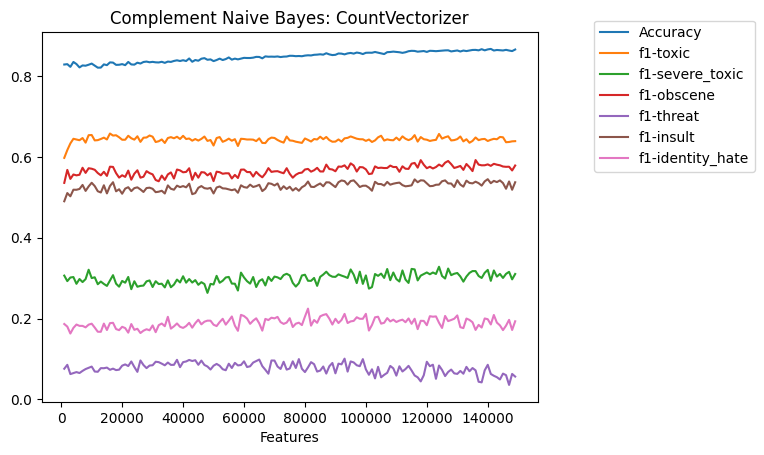

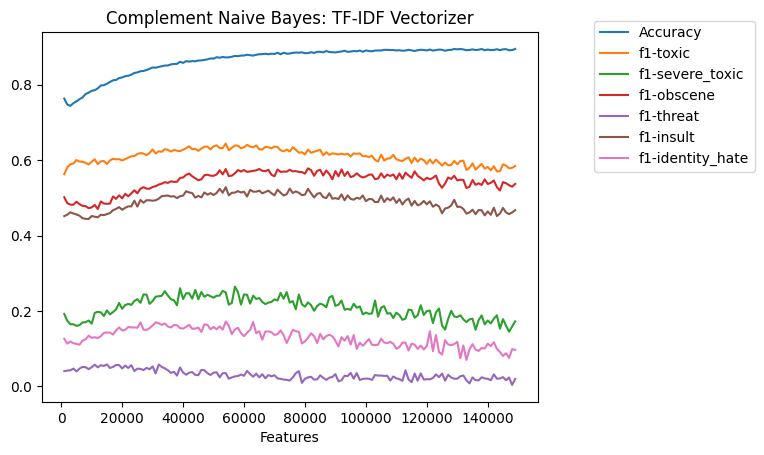

In [ ]:
plt.figure()
plt.plot(features_count_complement,acc_count_complement,label="Accuracy")
plt.plot(features_count_complement, f1_count_complement, label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Complement Naive Bayes: CountVectorizer")
plt.show()

plt.figure()
plt.plot(features_tfidf_complement,acc_tfidf_complement,label='Accuracy')
plt.plot(features_tfidf_complement,f1_tfidf_complement,label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Complement Naive Bayes: TF-IDF Vectorizer")
plt.show()

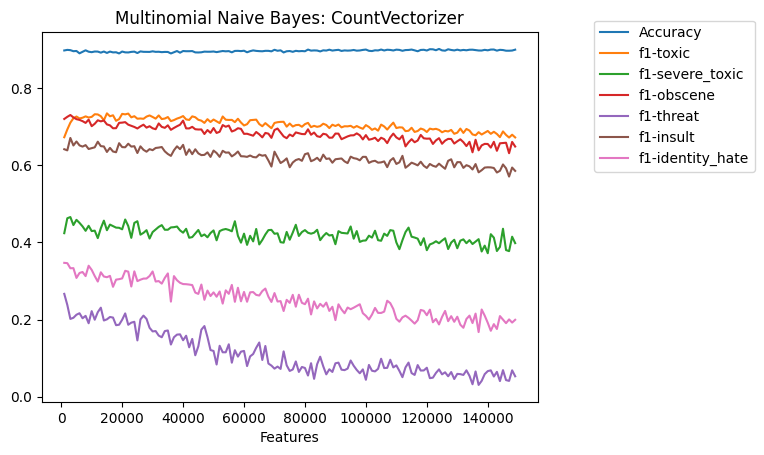

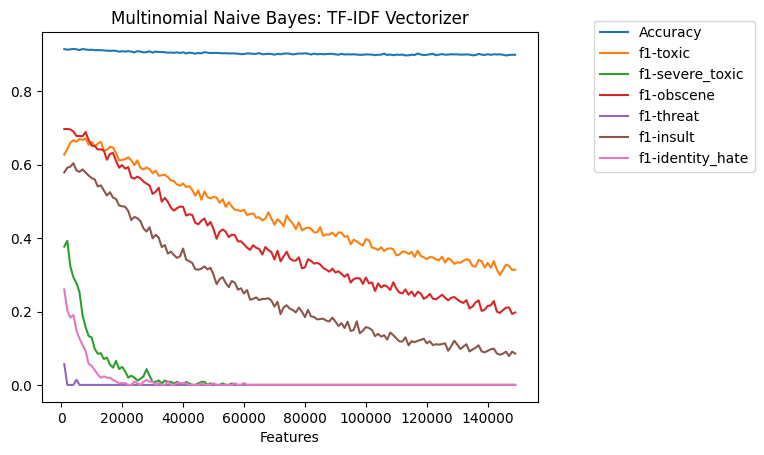

In [ ]:
plt.figure()
plt.plot(features_count_multi,acc_count_multi,label='Accuracy')
plt.plot(features_count_multi,f1_count_multi,label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Multinomial Naive Bayes: CountVectorizer")
plt.show()

plt.figure()
plt.plot(features_tfidf_multi,acc_tfidf_multi,label='Accuracy')
plt.plot(features_tfidf_multi,f1_tfidf_multi,label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Multinomial Naive Bayes: TF-IDF Vectorizer")
plt.show()

# Saving the results:

In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/tf_idf_complement_acc.np',acc_tfidf_complement)
np.save('/content/drive/MyDrive/tf_idf_complement_f1.np',f1_tfidf_complement)
np.save('/content/drive/MyDrive/count_complement_acc.np',acc_count_complement)
np.save('/content/drive/MyDrive/count_complement_f1.np',f1_count_complement)
np.save('/content/drive/MyDrive/tf_idf_multi_acc.np',acc_tfidf_multi)
np.save('/content/drive/MyDrive/tf_idf_multi_f1.np',f1_tfidf_multi)
np.save('/content/drive/MyDrive/count_multi_acc.np',acc_count_multi)
np.save('/content/drive/MyDrive/count_multi_f1.np',f1_count_multi)

# Understanding the results:

These results provide a comparative analysis of the performance of different combinations of Naive Bayes models and vectorization techniques. The Multinomial Naive Bayes model with TfidfVectorizer achieved the highest accuracy. However, the specific choice of model and vectorizer depends more importantly on the maximum f1 scores it is able to obtain. We therefore investigate the maximum F1-Scores for each vectorizer-NB architecture pair and the corresponding number of features. Since (as it can be seen from the graphs) different classes peak or decay in F1-Scores simultaneously (or at roughly the same feature size), we will only print the fcorresponding feature size for 'toxic' category.

In [3]:
import numpy as np
acc_tfidf_complement=np.load('/content/drive/MyDrive/tf_idf_complement_acc.np.npy')
f1_tfidf_complement=np.load('/content/drive/MyDrive/tf_idf_complement_f1.np.npy')
acc_count_complement=np.load('/content/drive/MyDrive/count_complement_acc.np.npy')
f1_count_complement=np.load('/content/drive/MyDrive/count_complement_f1.np.npy')
acc_tfidf_multi=np.load('/content/drive/MyDrive/tf_idf_multi_acc.np.npy')
f1_tfidf_multi=np.load('/content/drive/MyDrive/tf_idf_multi_f1.np.npy')
acc_count_multi=np.load('/content/drive/MyDrive/count_multi_acc.np.npy')
f1_count_multi=np.load('/content/drive/MyDrive/count_multi_f1.np.npy')

# make sure that you print what these values signify to alongside them as well
print("Maximum Accuracy: TF-IDF - Complement NB:","%.3f"% (100*np.max(acc_tfidf_complement)),'%')
print("Maximum Accuracy: Count - Complement NB:","%.3f"% (100*np.max(acc_count_complement)),'%')
print("Maximum Accuracy: TF-IDF - Multinomial NB:","%.3f"% (100*np.max(acc_tfidf_multi)),'%')
print("Maximum Accuracy: Count - Multinomial NB:","%.3f"% (100*np.max(acc_count_multi)),'%')

labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print("Maximum F1-Scores: TF-IDF - Complement NB:")
for i in range(len(labels)):
  print(labels[i],":","%.3f"% (100*np.max(f1_tfidf_complement[:,i])),'%')
print("Optimum Feature Size:",np.argmax(f1_tfidf_complement[:,0])*1000+1000)

print("Maximum F1-Scores: Count - Complement NB:")
for i in range(len(labels)):
  print(labels[i],":","%.3f"% (100*np.max(f1_count_complement[:,i])),'%')
print("Optimum Feature Size:",np.argmax(f1_count_complement[:,3])*1000+1000)

print("Maximum F1-Scores: TF-IDF - Multinomial NB:")
for i in range(len(labels)):
  print(labels[i],":","%.3f"% (100*np.max(f1_tfidf_multi[:,i])),'%')
print("Optimum Feature Size:",np.argmax(f1_tfidf_multi[:,1])*1000+1000)

print("Maximum F1-Scores: Count - Multinomial NB:")
for i in range(len(labels)):
  print(labels[i],":","%.3f"% (100*np.max(f1_count_multi[:,i])),'%')
print("Optimum Feature Size:",np.argmax(f1_count_multi[:,4])*1000+1000)


Maximum Accuracy: TF-IDF - Complement NB: 89.501 %
Maximum Accuracy: Count - Complement NB: 86.685 %
Maximum Accuracy: TF-IDF - Multinomial NB: 91.565 %
Maximum Accuracy: Count - Multinomial NB: 90.159 %
Maximum F1-Scores: TF-IDF - Complement NB:
toxic : 64.412 %
severe_toxic : 26.474 %
obscene : 57.836 %
threat : 5.834 %
insult : 52.831 %
identity_hate : 17.220 %
Optimum Feature Size: 54000
Maximum F1-Scores: Count - Complement NB:
toxic : 65.762 %
severe_toxic : 32.810 %
obscene : 59.200 %
threat : 10.084 %
insult : 54.469 %
identity_hate : 22.454 %
Optimum Feature Size: 93000
Maximum F1-Scores: TF-IDF - Multinomial NB:
toxic : 67.167 %
severe_toxic : 39.281 %
obscene : 69.735 %
threat : 5.674 %
insult : 60.424 %
identity_hate : 26.025 %
Optimum Feature Size: 2000
Maximum F1-Scores: Count - Multinomial NB:
toxic : 73.458 %
severe_toxic : 46.581 %
obscene : 73.030 %
threat : 26.667 %
insult : 67.080 %
identity_hate : 34.707 %
Optimum Feature Size: 3000


An interesting observation here is that the F1-Scores remain relatively stable over feature size for ComplementNB, but decay as feature size increases for Multinomial NB. Regardless, a quick observation of the graphs tells us that the median values of feature vectors are suitable for good F1-Scores except for TF-IDF with Mutlinomial which decays rapidly, and therefore, for balanced datasets we will employ this median range.

# Repeating for Balanced Datasets (over a smaller range (40,000 to 80,000 features)):

In this section of the notebook, we investigate the effects of varying feature counts on the performance of balanced datasets using Naive Bayes classifiers, specifically Complement Naive Bayes and Multinomial Naive Bayes. The objective is to gauge the generalization capability of these models on balanced datasets comprising equal instances of toxic and non-toxic comments. A function, balanced_effects, is defined which iterates over different feature counts, ranging from 40,000 to 76,000 in steps of 2,000. In each iteration, the function computes and logs accuracies and F1 scores for each toxic category using various balanced training sets.

The training sets encompass instances of toxic comments that have been balanced with non-toxic comments for each toxic category. Two vectorization techniques, CountVectorizer and TfidfVectorizer, are utilized, and the function yields lists of accuracies, F1 scores, and corresponding feature values.

The balanced_effects function is subsequently invoked for both Complement Naive Bayes and Multinomial Naive Bayes models with CountVectorizer and TfidfVectorizer. Following this, Matplotlib is employed to generate four plots for each model and vectorization method. Each plot depicts the variation in accuracy and F1 scores with an increasing number of features for different toxic categories. These visualizations offer insights into the performance of the models on balanced datasets and assist in identifying optimal configurations for feature counts.

The plots for Complement Naive Bayes and Multinomial Naive Bayes using both CountVectorizer and TfidfVectorizer demonstrate how varying feature counts influence the model’s proficiency in accurately classifying toxic and non-toxic comments. These analyses contribute to valuable insights for selecting optimal hyperparameters in better future model deployment.

In [ ]:
def balanced_effects(vectorizer,model,train_sets):
  accuracies=[]
  f1_scores=[]
  max_features=[]
  weights=3*sums.to_numpy()
  for i in range (1,20):
    word=2000*i+40000;
    max_features.append(word)
    vec = vectorizer(max_features=word)
    vec.fit(process_train['comment_text'])
    # learns features from complete vocab available (this will remain invariant to both balanced and unbalanced datasets for fair comparison)
    f1_set=[]
    accuracy_set=[]
    for t_set in train_sets:
      X_train,X_val,Y_train,Y_val=train_test_split(t_set['comment_text'],t_set.drop(columns='comment_text').to_numpy(),test_size=0.3)
      X_train=vec.transform(X_train)
      X_val=vec.transform(X_val)
      classifier=model.fit(X_train,Y_train.ravel())
      predicted_labels=classifier.predict(X_val)
      f1=f1_score(Y_val.ravel(),predicted_labels,average=None)
      f1_set.append(f1[0])
      accuracy=accuracy_score(Y_val.ravel(),predicted_labels)
      accuracy_set.append(accuracy)
    f1_scores.append(f1_set)
    accuracy_set=np.dot(accuracy_set,weights)
    accuracy_set=accuracy_set/np.sum(weights)
    accuracies.append(accuracy_set)
  return accuracies,f1_scores,max_features

train_sets=[balanced_toxic,balanced_severe_toxic,balanced_obscene,balanced_threat,balanced_insult,balanced_identity_hate]
acc_count_complement,f1_count_complement,features_count_complement=balanced_effects(CountVectorizer,ComplementNB(),train_sets)
acc_tfidf_complement,f1_tfidf_complement,features_tfidf_complement=balanced_effects(TfidfVectorizer,ComplementNB(),train_sets)
acc_count_multi,f1_count_multi,features_count_multi=balanced_effects(CountVectorizer,MultinomialNB(),train_sets)
acc_tfidf_multi,f1_tfidf_multi,features_tfidf_multi=balanced_effects(TfidfVectorizer,MultinomialNB(),train_sets)

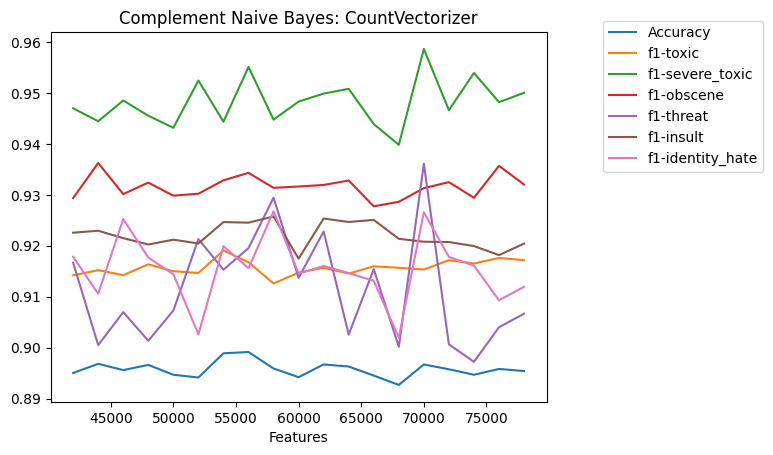

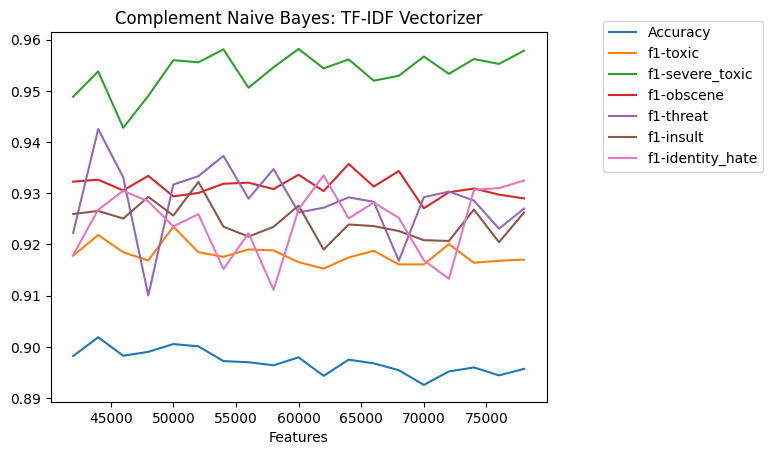

In [ ]:
plt.figure()
plt.plot(features_count_complement,acc_count_complement,label="Accuracy")
plt.plot(features_count_complement, f1_count_complement, label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Complement Naive Bayes: CountVectorizer")
plt.show()

plt.figure()
plt.plot(features_tfidf_complement,acc_tfidf_complement,label='Accuracy')
plt.plot(features_tfidf_complement,f1_tfidf_complement,label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Complement Naive Bayes: TF-IDF Vectorizer")
plt.show()


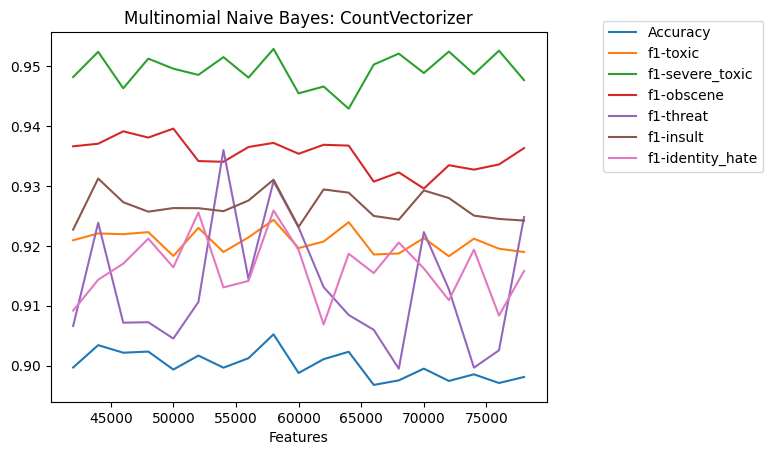

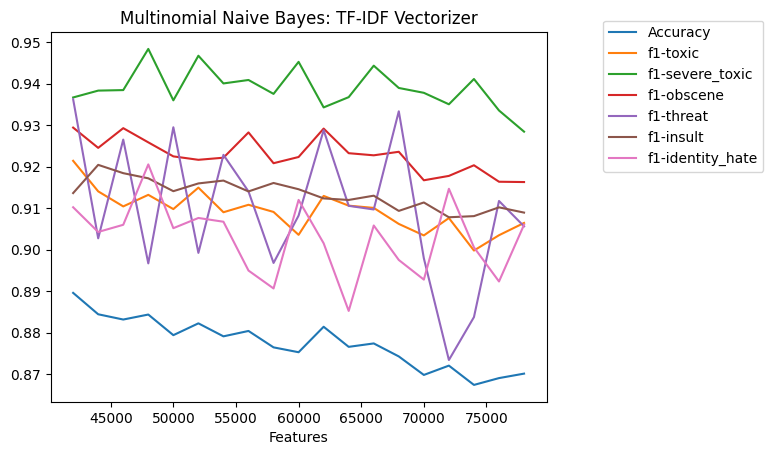

In [ ]:
plt.figure()
plt.plot(features_count_multi,acc_count_multi,label='Accuracy')
plt.plot(features_count_multi,f1_count_multi,label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Multinomial Naive Bayes: CountVectorizer")
plt.show()

plt.figure()
plt.plot(features_tfidf_multi,acc_tfidf_multi,label='Accuracy')
plt.plot(features_tfidf_multi,f1_tfidf_multi,label =['f1-toxic','f1-severe_toxic','f1-obscene','f1-threat','f1-insult','f1-identity_hate'])
plt.xlabel("Features")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Multinomial Naive Bayes: TF-IDF Vectorizer")
plt.show()

A quick observation of the graphs shows that the values are relatively stable in this range. A far more important observation is the high values of F1-Scores that balanced datasets give, showing that balanced datasets are indeed more valuable, or at least equally as valuable as large datasets for good training. This concept will be carried on to the next model where we discuss RNN and LSTMS.

# Testing the Optimal Model (Highest Validation F1-Scores and Accuracy) on the Unbalanced Raw Training Data:

Here we are testing two different setups of Naive Bayes classifiers on two different types of datasets: unbalanced raw training data and balanced training data. The goal is to evaluate the performance of these models in classifying toxic comments.

In the first part, the Multinomial Naive Bayes model is trained on the unbalanced raw training data using CountVectorizer with a maximum of 70,000 features. The model is then used to predict the labels of the test data. The F1 scores, accuracy, and AUC (Area Under the ROC Curve) are calculated to evaluate the model’s performance.

In the second part, a function balanced_train is defined to train the Multinomial Naive Bayes model on balanced training data using TfidfVectorizer. The balanced training data contains equal instances of toxic and non-toxic comments for each category. The function iterates over different training sets, trains the model, and predicts the labels of the test data. The F1 scores, accuracy, and AUC are then calculated.

> Firstly on the unbalanced data:

In [ ]:
model=MultinomialNB()
vec=CountVectorizer(max_features=70000)
vec.fit(process_train['comment_text'])
X_train=vec.transform(process_train['comment_text'])
Y_train=process_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_transform=vec.transform(X_test)
multi_model=MultiOutputClassifier(model)
multi_model.fit(X_train,Y_train)
predicted_labels=multi_model.predict(X_transform)
f1=f1_score(Y_test,predicted_labels,average=None)
accuracy=accuracy_score(Y_test,predicted_labels)
AUC=roc_auc_score(Y_test,predicted_labels)
print_results(f1,AUC,accuracy)

F1 Scores:
toxic : 60.294 %
severe_toxic : 21.571 %
obscene : 56.272 %
threat : 6.102 %
insult : 51.568 %
identity_hate : 22.231 %
AUC: : 75.650 %
Accuracy: : 85.198 %


> Now on the balanced training data:

In [ ]:
def balanced_train(vectorizer,model,train_sets,word):
  f1_scores=[]
  labels=[]
  vec = vectorizer(max_features=word)
  vec.fit(process_train['comment_text'])
  X_transform_test=vec.transform(X_test)
  for t_set in train_sets:
    X_train=vec.transform(t_set['comment_text'])
    classifier=model.fit(X_train,t_set.drop(columns='comment_text').to_numpy().ravel())
    predicted_labels=classifier.predict(X_transform_test)
    labels.append(predicted_labels)
  labels=np.array(labels).T
  accuracy=accuracy_score(Y_test,labels)
  f1_scores=f1_score(Y_test,labels,average=None)
  AUC=roc_auc_score(Y_test,labels)
  return accuracy,f1_scores,AUC

train_sets=[balanced_toxic,balanced_severe_toxic,balanced_obscene,balanced_threat,balanced_insult,balanced_identity_hate]
#test_labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
accuracy,f1_scores,AUC=balanced_train(TfidfVectorizer,MultinomialNB(),train_sets,70000)
print_results(f1,AUC,accuracy)

F1 Scores:
toxic : 60.294 %
severe_toxic : 21.571 %
obscene : 56.272 %
threat : 6.102 %
insult : 51.568 %
identity_hate : 22.231 %
AUC: : 80.743 %
Accuracy: : 86.922 %


For the first part, the F1 scores for each category (‘toxic’, ‘severe_toxic’, ‘obscene’, ‘threat’, ‘insult’, ‘identity_hate’) range from 6.102% to 60.294%, indicating varying levels of performance across different categories. The overall accuracy is 85.198% and the AUC is 75.650%.

In the second part, the F1 scores for each category are the same as in the first part, but the overall accuracy has increased to 86.922% and the AUC has increased to 80.743%.

These results suggest that while the F1 scores for each category remain the same, the overall accuracy and AUC have improved when the model is trained on balanced data. This indicates that balancing the training data can improve the model’s ability to generalize and make accurate predictions. However, the relatively low F1 scores for some categories (‘threat’, ‘severe_toxic’, ‘identity_hate’) suggest that the model struggles to correctly identify these forms of toxicity. Further investigation and potentially different approaches might be needed to improve the performance for these categories.

# Is there a need for balancing test data?

> Investigating potential test data imbalances:

Here, we create balanced test datasets for each specific toxic category, such as 'toxic,' 'severe_toxic,' 'obscene,' 'threat,' 'insult,' and 'identity_hate. For each category, we  concatenate the instances where the toxic label is 1 (indicating a toxic comment) with a randomly sampled subset of non-toxic instances (where the toxic label is 0). The non-toxic instances are sampled without replacement and are selected to be twice the number of toxic instances for that category, ensuring a balanced distribution.

The resulting balanced test datasets are then shuffled using the sample(frac=1) method to randomize the order of instances. Subsequently, we select and retains only the 'comment_text' and the corresponding toxic label columns for each category, forming the final balanced test datasets.

Finally, we print the shape (number of rows and columns) of each balanced test dataset, providing insights into the size and structure of the created datasets. The printed information includes the shapes for 'toxic,' 'insult,' 'obscene,' 'severe_toxic,' 'threat,' and 'identity_hate' test datasets.

<Axes: title={'center': 'Toxic Ratios'}, ylabel='Frequency'>

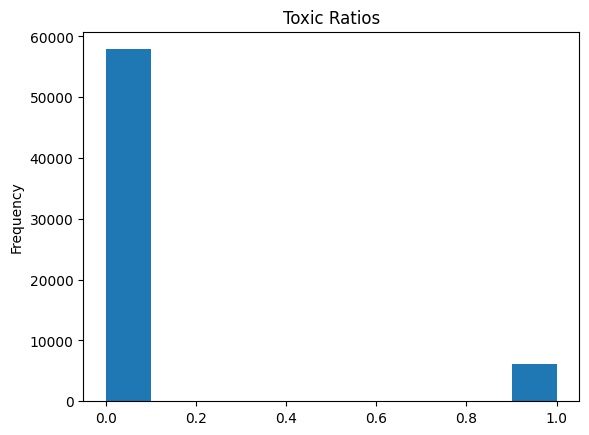

In [ ]:
ratios=test_set.drop(columns=['comment_text'])
ratios['toxic'].plot(kind='hist',title='Toxic Ratios')

toxic            6090
severe_toxic      367
obscene          3691
threat            211
insult           3427
identity_hate     712
dtype: int64


<Axes: title={'center': 'Toxic Samples Breakdown - Test'}>

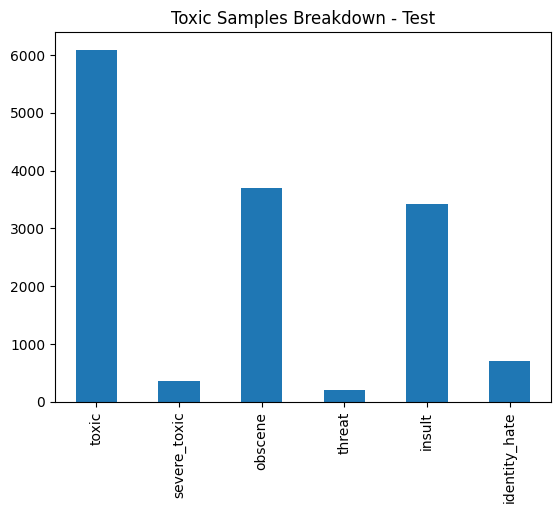

In [ ]:
sums_test=ratios[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum()
print(sums_test)
sums_test.plot(kind='bar',title='Toxic Samples Breakdown - Test')

In [ ]:
balanced_toxic_test=pd.concat([test_set[test_set['toxic']==1],test_set[test_set['toxic']==0].sample(frac=1).iloc[:int(2*sums['toxic'])]],ignore_index=True).sample(frac=1)
balanced_severe_toxic_test=pd.concat([test_set[test_set['severe_toxic']==1],test_set[test_set['severe_toxic']==0].sample(frac=1).iloc[:int(2*sums['severe_toxic'])]],ignore_index=True).sample(frac=1)
balanced_obscene_test=pd.concat([test_set[test_set['obscene']==1],test_set[test_set['obscene']==0].sample(frac=1).iloc[:int(2*sums['obscene'])]],ignore_index=True).sample(frac=1)
balanced_threat_test=pd.concat([test_set[test_set['threat']==1],test_set[test_set['threat']==0].sample(frac=1).iloc[:int(2*sums['threat'])]],ignore_index=True).sample(frac=1)
balanced_insult_test=pd.concat([test_set[test_set['insult']==1],test_set[test_set['insult']==0].sample(frac=1).iloc[:int(2*sums['insult'])]],ignore_index=True).sample(frac=1)
balanced_identity_hate_test=pd.concat([test_set[test_set['identity_hate']==1],test_set[test_set['identity_hate']==0].sample(frac=1).iloc[:int(2*sums['identity_hate'])]],ignore_index=True).sample(frac=1)

balanced_toxic_test=balanced_toxic_test[['comment_text','toxic']]
balanced_severe_toxic_test=balanced_severe_toxic_test[['comment_text','severe_toxic']]
balanced_obscene_test=balanced_obscene_test[['comment_text','obscene']]
balanced_threat_test=balanced_threat_test[['comment_text','threat']]
balanced_insult_test=balanced_insult_test[['comment_text','insult']]
balanced_identity_hate_test=balanced_identity_hate_test[['comment_text','identity_hate']]

In [ ]:
print(balanced_toxic_test.shape)
print(balanced_insult_test.shape)
print(balanced_obscene_test.shape)
print(balanced_severe_toxic_test.shape)
print(balanced_threat_test.shape)
print(balanced_identity_hate_test.shape)

(36678, 2)
(19181, 2)
(20589, 2)
(3557, 2)
(1167, 2)
(3522, 2)


# What if we balance the testing data as well?

> Using both balanced training and testing data:

In [ ]:
test_labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
def balanced_train(vectorizer,model,train_sets,test_sets,word):
  f1_scores=[]
  accuracies=[]
  AUCs=[]
  vec = vectorizer(max_features=word)
  vec.fit(process_train['comment_text'])
  for i in range(len(train_sets)):
    X_train=vec.transform(train_sets[i]['comment_text'])
    X_transform_test=vec.transform(test_sets[i]['comment_text'])
    Y_test=test_sets[i].drop(columns='comment_text')
    classifier=model.fit(X_train,train_sets[i].drop(columns='comment_text').to_numpy().ravel())
    predicted_labels=classifier.predict(X_transform_test)
    accuracies.append(accuracy_score(Y_test,predicted_labels))
    f1_scores.append(f1_score(Y_test,predicted_labels))
    AUCs.append(roc_auc_score(Y_test,predicted_labels))
  return accuracies,f1_scores,AUCs

train_sets=[balanced_toxic,balanced_severe_toxic,balanced_obscene,balanced_threat,balanced_insult,balanced_identity_hate]
test_sets=[balanced_toxic_test,balanced_severe_toxic_test,balanced_obscene_test,balanced_threat_test,balanced_insult_test,balanced_identity_hate_test]
accuracy,f1_scores,AUCs=balanced_train(TfidfVectorizer,MultinomialNB(),train_sets,test_sets,70000)
for i in range(len(test_labels)):
  print(test_labels[i],":")
  print("F1 score:","%.3f"% (f1_scores[i]*100),"%")
  print("AUC:","%.3f"% (AUCs[i]*100),"%")
  print("Accuracy:","%.3f"% (accuracy[i]*100),"%")

toxic :
F1 score: 69.553 %
AUC: 81.155 %
Accuracy: 90.163 %
severe_toxic :
F1 score: 72.727 %
AUC: 84.043 %
Accuracy: 94.518 %
obscene :
F1 score: 71.959 %
AUC: 81.078 %
Accuracy: 90.786 %
threat :
F1 score: 73.654 %
AUC: 80.178 %
Accuracy: 92.031 %
insult :
F1 score: 68.305 %
AUC: 78.648 %
Accuracy: 89.849 %
identity_hate :
F1 score: 72.153 %
AUC: 79.463 %
Accuracy: 90.488 %


These results look great, not only does it show the importance of balanced datasets but also the power of Naive Bayes, a probabilistic classifier, which might beat even neural networks on preformance.

> Let's find an average AUC, f1_score, and accuracy:

In [ ]:
weights_test=weights=3*sums_test.to_numpy()
average_AUC=np.mean(np.array(AUCs))
average_f1=np.mean(np.array(f1_scores))
average_accuracy=np.mean(np.array(accuracy))
w_average_AUC=np.mean(np.dot(weights_test,np.array(AUCs)))/np.sum(weights_test)
w_average_f1=np.mean(np.dot(weights_test,np.array(f1_scores)))/np.sum(weights_test)
w_average_accuracy=np.mean(np.dot(weights_test,np.array(accuracy)))/np.sum(weights_test)
print("Average AUC:","%.3f"% (average_AUC*100),"%")
print("Average F1-Score:","%.3f"% (average_f1*100),"%")
print("Average Accuracy:","%.3f"% (average_accuracy*100),"%")
print("Weighted Average AUC:","%.3f"% (w_average_AUC*100),"%")
print("Weighted Average F1-Score:","%.3f"% (w_average_f1*100),"%")
print("Weighted Average Accuracy:","%.3f"% (w_average_accuracy*100),"%")

Average AUC: 80.761 %
Average F1-Score: 71.392 %
Average Accuracy: 91.306 %
Weighted Average AUC: 80.519 %
Weighted Average F1-Score: 70.138 %
Weighted Average Accuracy: 90.401 %


Clearly balanced subsets of training data trained on balanced subsets of test data give the best results.In imbalanced datasets, where one class has significantly more samples than the other, the model might become biased toward the majority class. Balanced datasets, on the other hand allow for more generalization by the trained model, which was observed when we shifted from unabalanced training to balanced training sets (by an increase in F1 score on average, as well as AUC score). Since the model is trained on balanced datasets and tested on unabalanced with majority negative instances (the distribution D being trained on is vastly different from the real population P), results therefore do not significantly improve, but still do by a small margin. The greatest effect is seen when both training and test data now consist of balanced subsets, which allows the power of Naive Bayes to be unleashed in its full glory.

# Do Away with the sparse vectors. Why not use dense representations?
 **Breaking the "naive" assumption**:

> Let's use Word2vec with Multinomial Naive Bayes and Imbalanced Data instead:

In [ ]:
from gensim.models import Word2Vec
import numpy as np
def split(text):
  return text.split()
word2vec_model = Word2Vec(sentences=process_train['comment_text'].apply(split), vector_size=100, window=5, min_count=1, workers=4)

def average_word2vec(tokens):
    vector_sum = np.zeros(100)
    count = 0
    for word in tokens:
        if word in word2vec_model.wv:
            vector_sum += word2vec_model.wv[word]
            count += 1
    if count > 0:
        return vector_sum / count
    else:
        return np.zeros(100)

In [ ]:
def balanced_train(train_sets,test_sets):
  f1_scores=[]
  accuracies=[]
  AUCs=[]
  for i in range(len(train_sets)):
    process_train_vec =np.vstack(train_sets[i]['comment_text'].apply(average_word2vec).to_numpy())
    process_test_vec=np.vstack(test_sets[i]['comment_text'].apply(average_word2vec).to_numpy())
    classifier = GaussianNB()
    classifier.fit(process_train_vec,train_sets[i].drop(columns='comment_text').to_numpy().ravel())
    Y_test=test_sets[i].drop(columns='comment_text')
    predicted_labels=classifier.predict(process_test_vec)
    f1=f1_score(Y_test,predicted_labels,average=None)
    accuracy=accuracy_score(Y_test,predicted_labels)
    AUC=roc_auc_score(Y_test,predicted_labels)
    accuracies.append(accuracy_score(Y_test,predicted_labels))
    f1_scores.append(f1_score(Y_test,predicted_labels))
    AUCs.append(roc_auc_score(Y_test,predicted_labels))
  return accuracies,f1_scores,AUCs

train_sets=[balanced_toxic,balanced_severe_toxic,balanced_obscene,balanced_threat,balanced_insult,balanced_identity_hate]
test_sets=[balanced_toxic_test,balanced_severe_toxic_test,balanced_obscene_test,balanced_threat_test,balanced_insult_test,balanced_identity_hate_test]
accuracy,f1_scores,AUCs=balanced_train(train_sets,test_sets)
for i in range(len(train_sets)):
  print(test_labels[i],":")
  print("F1 score:","%.3f"% (f1_scores[i]*100),"%")
  print("AUC:","%.3f"% (AUCs[i]*100),"%")
  print("Accuracy:","%.3f"% (accuracy[i]*100),"%")

toxic :
F1 score: 36.066 %
AUC: 61.997 %
Accuracy: 74.693 %
severe_toxic :
F1 score: 32.156 %
AUC: 65.168 %
Accuracy: 79.477 %
obscene :
F1 score: 37.912 %
AUC: 62.365 %
Accuracy: 74.355 %
threat :
F1 score: 42.105 %
AUC: 65.283 %
Accuracy: 75.493 %
insult :
F1 score: 37.611 %
AUC: 62.172 %
Accuracy: 74.730 %
identity_hate :
F1 score: 43.571 %
AUC: 64.743 %
Accuracy: 75.951 %


# Results:


Clearly, it is not the best practice to use Naive Bayes while violating its basic assumptions (this can be observed by comparing the results of Word2Vec model with the best model we trained using balanced datasets and MultinomialNB with TF-IDF Vectors). While Word2Vec vectors are not inherently discrete, our approach averages the vectors, making them more amenable to a Gaussian distribution assumption.

However, in practice, when working with Word2Vec embeddings, it's common to use classifiers that are more suitable for continuous vectors, such as Neural Networks and its derivatives, RandomForest etc. For now, we close our experiments on Naive Bayes and Spare Representations, and move to the deeper RNN, and bi-directional LSTM models with dense pretrained vector representations having semantics embedded (Embeddings) including Word2Vec, GloVe as well as self-trained embeddings in the next notebook.


*Some possible future work:*

>Exploring *n-grams* for Naive Bayes:

Incorporating "n-grams" into the Naive Bayes classification process could potentially enhance our model's understanding of language. N-grams are basically sequences of n items, often words in natural language processing. Our current model uses individual words as features, but n-grams may allow it to consider relationships between adjacent words, particularly useful for understanding phrases or expressions.

Including bi-grams (two-word sequences) or tri-grams (three-word sequences) can also provide a more detailed view of comment structure. This captures subtle nuances in toxicity conveyed through specific word combinations. However, larger n-gram sizes would increase the feature space dimensionality, which can lead to higher computational complexity and overfitting risk.

To implement n-grams in Naive Bayes, the vectorization process needs to be adapted to consider these sequences. This involves modifying the feature extraction step to include word combinations up to the desired n-gram order. The model training process would then accommodate these extended features, potentially improving its ability to discern complex linguistic structures. In short, using n-grams with Naive Bayes can refine the model's language comprehension and improve its performance in identifying toxic comments. This aligns well with our goal of optimizing the model by incorporating advanced linguistic features.

>Exploring *adaptive* Naive Bayes techniques:

Adaptive Naive Bayes techniques offer a promising refinement for our toxicity classification model. Unlike traditional Naive Bayes, which assumes feature independence, adaptive methods adjusts the model based on data patterns. This actually proves crucial for toxic language, where word dependencies provide important context.

An adaptive Naive Bayes model basically updates its parameters during training, adapting to the dataset's linguistic characteristics. This dynamic approach captures the changing dependencies, potentially enhancing the model's discrimination capabilities.

The exploration involves adaptive strategies that allow the model to adjust its probabilistic estimates with new information. Techniques like incremental updating or Bayesian online learning can also be used here, enabling the model to adapt to language patterns over time. This adaptability could improve the Naive Bayes classifier's accuracy in identifying toxic language expression.